# Imports/Setup

In [1]:
import os
import sys
import urllib
from collections import defaultdict

import numpy as np

from astropy import units as u
from astropy import table
from astropy.coordinates import SkyCoord, EarthLocation, get_sun
from astropy.time import Time
from astropy.io import fits

import astroquery

from importlib import reload

%matplotlib inline
from matplotlib import style, pyplot as plt

In [3]:
working_dir = os.path.abspath('..')

%cd ../../saga
sagadir = !pwd
sagadir = sagadir[0]
!python setup.py build
%cd $working_dir

/Users/erik/projects/saga/saga
running build
running build_py
/Users/erik/projects/saga/erik


In [4]:
sagalibdir = os.path.join(sagadir, 'build/lib')
print('Adding', sagalibdir, 'to the python path')
sys.path.insert(0, sagalibdir)

from SAGA.database.external import SdssQuery, DesQuery, download_catalogs_for_hosts
import SAGA as saga

Adding /Users/erik/projects/saga/saga/build/lib to the python path


# Get Data

In [5]:
# get host list
saga_database = saga.Database(os.path.join(os.environ['HOME'],'Dropbox/SAGA/'))
saga_host_catalog = saga.HostCatalog(saga_database)

In [7]:
hosts_to_load = 'has_des'
des_hosts = saga_host_catalog.load(hosts_to_load)
des_hosts['ID_STR'] = saga_host_catalog.resolve_id(hosts_to_load, 'string')

failed = download_catalogs_for_hosts(des_hosts, DesQuery, saga_database.des_file_path_pattern, overwrite=False, host_id_label=host_id_label)

print('# failed =', np.count_nonzero(failed))

[06/04 01:36:28] Getting catalog for host pgc1952 ...
[06/04 01:36:28] Getting catalog for host pgc2052 ...
[06/04 01:36:28] Getting catalog for host pgc2778 ...
[06/04 01:36:28] Getting catalog for host pgc3089 ...
[06/04 01:36:28] Getting catalog for host pgc5619 ...
[06/04 01:36:28] Getting catalog for host nsa130133 ...
[06/04 01:36:28] Getting catalog for host nsa130625 ...
[06/04 01:36:28] Getting catalog for host pgc9057 ...
[06/04 01:36:28] Getting catalog for host pgc9747 ...
[06/04 01:36:28] Getting catalog for host nsa132278 ...
[06/04 01:36:28] Getting catalog for host nsa132339 ...
[06/04 01:36:28] Getting catalog for host pgc10330 ...
[06/04 01:36:28] Getting catalog for host pgc10965 ...
[06/04 01:36:28] Getting catalog for host pgc771919 ...
[06/04 01:36:28] Getting catalog for host pgc11819 ...
[06/04 01:36:28] Getting catalog for host pgc12007 ...
[06/04 01:36:28] Getting catalog for host pgc12431 ...
[06/04 01:36:28] Getting catalog for host nsa133355 ...
[06/04 01:3

In [27]:
hosts_to_load = 'flag0'
flag0_hosts = saga_host_catalog.load(hosts_to_load)
flag0_hosts['ID_STR'] = saga_host_catalog.resolve_id(hosts_to_load, 'string')

In [10]:
nsahost = flag0_hosts[flag0_hosts['NSAID']==145398][0]
#path = '/home/yymao/Downloads/test.fits.gz'
qry = SdssQuery(nsahost['RA'], nsahost['Dec'], context='DR14', default_use_sciserver=False)
qry.download_as_file(saga_database.sdss_file_path_pattern.format('nsa' + str(host['NSAID'])), overwrite=False)

[06/04 01:40:49] casjob (SAGAfyay) submitted...
[06/04 01:42:11] casjob (SAGAfyay) finished, downloading data...


In [54]:
nsahost = flag0_hosts[flag0_hosts['NSAID']==145398][0]
deshost = des_hosts[des_hosts['PGC'] == 2052][0]

Manually went to IRSA to download all of the USNO-B1, UCAC, URAT survets

In [71]:
from astroquery.gaia import Gaia

In [ ]:
nsa_gaiajob = Gaia.cone_search_async(nsahost['coord'], radius=1*u.deg)
nsa_gaia = nsa_gaiajob.get_data()
nsa_gaia.write('external_catalogs/astrometric/nsa145398_gaia.ecsv', format='ascii.ecsv')
len(nsa_gaia)

In [ ]:
des_gaiajob = Gaia.cone_search_async(deshost['coord'], radius=1*u.deg)
des_gaia = des_gaiajob.get_data()
des_gaia.write('external_catalogs/astrometric/pgc2052_gaia.ecsv', format='ascii.ecsv')
len(des_gaia)

# Compare Catalogs

In [132]:
mag_field_names = {}
mag_field_names['desdr1'] = 'r_mag'
mag_field_names['2mass'] = 'j_m'
mag_field_names['ucac5'] = 'rmag'
mag_field_names['usno_b1'] = 'r1_mag'
mag_field_names['sdss'] = 'r'
mag_field_names['urat'] = 'jmag'
mag_field_names['gaia'] = 'phot_g_mean_mag'

We start with an SDSS/NSA host for testing purposes.  There's no need for independent guide stars because SDSS's "bright chip" gives astrometric accuracy even for fairly bright stars.  But it's a good check to see how well the astrometric catalogs work, for comparison with the DES case.

## SDSS Host (NSA 632028/NGC 5701)

In [221]:
nsahost

SAGA_name,NSAID,RA,Dec,PGC,NSA1ID,NGC,UGC,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,RA_sub,Dec_sub,othername,vhelio_sub,vhelio_err,distance_sub,dist_2MASS_NSA,u,u_err,A_u,M_u,g,g_err,A_g,M_g,r_sub,r_err,A_r,M_r,i_sub,i_err,A_i,M_i,z_sub,z_err,A_z,M_z,J,J_err,A_J,M_J,H,H_err,A_H,M_H,K_sub,K_err_sub,A_K,M_K,stellar_mass,sersic_n,MK_compiled,des_dr1,decals_dr5,decals_dr6,coord,ID_STR
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",
str11,int64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,str16,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,object,str9
--,145398,219.796,5.36347,52365,632028,5701,9436,1505.0,23.5261,11.882,11.5062,11.2418,--,8.128,0.027,0,-23.7298,-19.9757,56.3646,5.04108,--,0.985748,219.796,5.36347,NGC_5701,1505.0,-1,23.5261,0.767715,13.8336,0.00262602,0.160544,-18.1998,12.0022,0.000570718,0.125095,-19.994,11.1937,0.000521171,0.08654,-20.7557,10.7746,0.000517865,0.0643085,-21.1522,10.4734,0.000993887,0.0478337,-21.4355,9.062,0.016,0.026852,-22.8212,8.358,0.017,0.017005,-23.5161,8.141,0.026,0.0114377,-23.7178,14300000000,2.68922,-23.7298,0.0,1.0,0.0,"219.796,5.36347",nsa145398


In [222]:
nsahost_tables = {}
nsahost_tables['sdss'] = table.Table.read('external_catalogs/sdss_dr14/{}.fits.gz'.format(nsahost['ID_STR']))
nsahost_tables['2mass'] = table.Table.read('external_catalogs/astrometric/{}_2mass.tbl'.format(nsahost['ID_STR']),
                                           format='ascii')
nsahost_tables['ucac5'] = table.Table.read('external_catalogs/astrometric/{}_ucac5.tbl'.format(nsahost['ID_STR']),
                                           format='ascii')
nsahost_tables['usno_b1'] = table.Table.read('external_catalogs/astrometric/{}_usno_b1.tbl'.format(nsahost['ID_STR']),
                                           format='ascii')
nsahost_tables['urat'] = table.Table.read('external_catalogs/astrometric/{}_urat.tbl'.format(nsahost['ID_STR']),
                                           format='ascii')
nsahost_tables['gaia'] = table.Table.read('external_catalogs/astrometric/{}_gaia.ecsv'.format(nsahost['ID_STR']),
                                           format='ascii.ecsv')

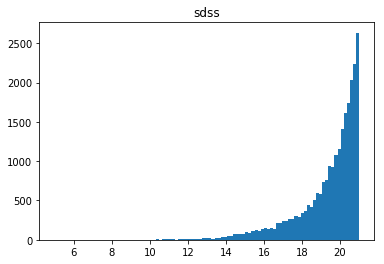

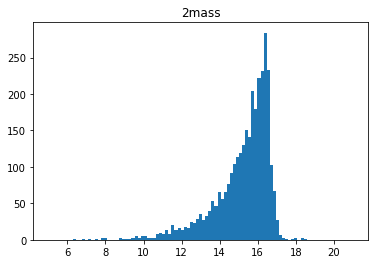

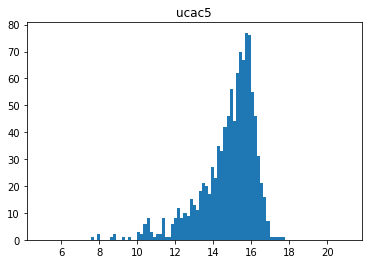

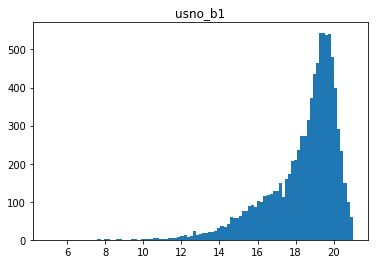

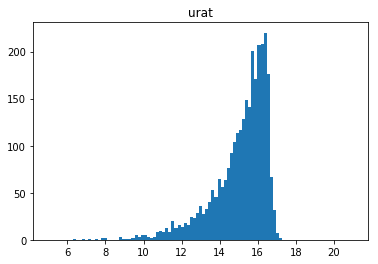

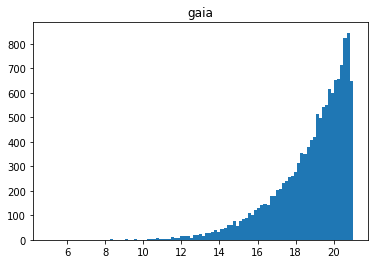

In [230]:
bins = np.linspace(5,21, 100)
for key in nsahost_tables:
    plt.figure()
    plt.hist(nsahost_tables[key][mag_field_names[key]], bins=bins)
    plt.title(key)

The first column gives the matches between the catalogs - the peaks at the left are "real" matchs.

The second column of the plots below are the offset from DES to each of the astrometric sources, for stars with r mags in the 16-17 range (which is a rough area of overlap for all the surveys).  It also gives various statistics for those matches, particularly the *mean* offset between the catalogs (the red dot, relative to the black dot which is a 0-offset)

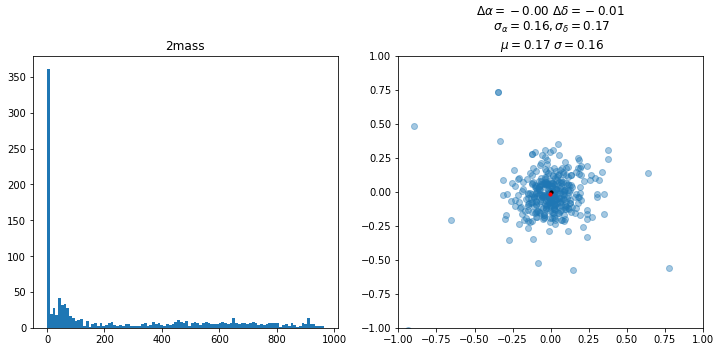

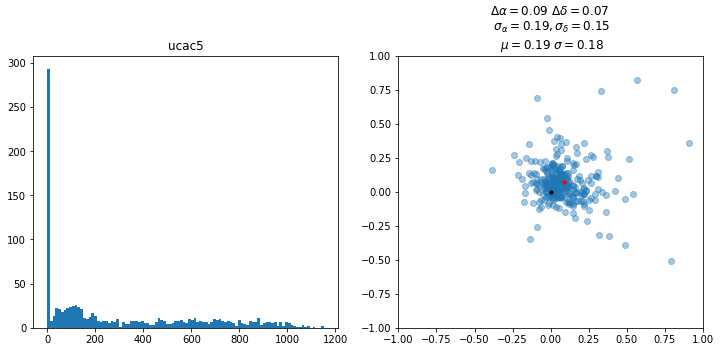

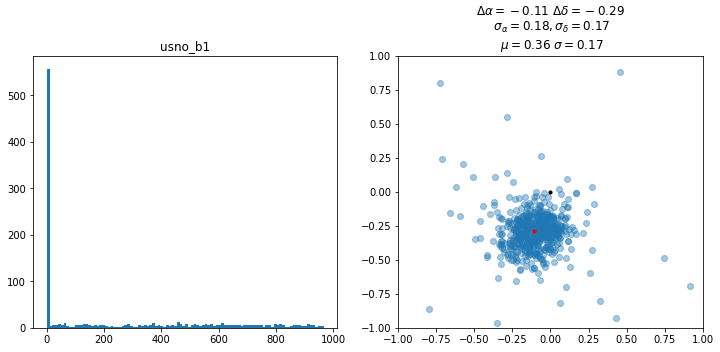

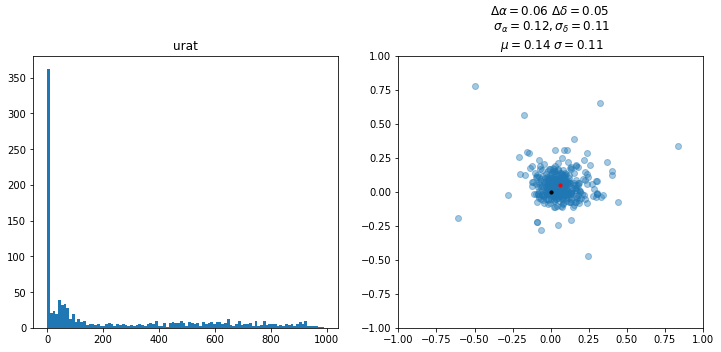

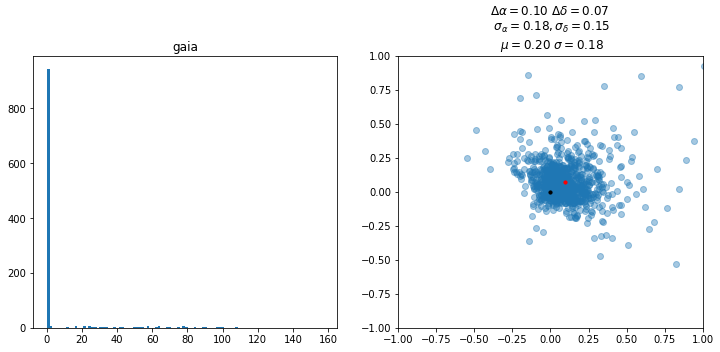

In [253]:
nsc = SkyCoord(nsahost_tables['sdss']['RA'], nsahost_tables['sdss']['DEC'], unit=u.deg)
nmag = nsahost_tables['sdss'][mag_field_names['sdss']]

magrng = (16, 17)
d_matchmag = 1

nsc_msk = nsc[(magrng[0]<nmag)&(nmag<magrng[1])]

for key in nsahost_tables:
    if key == 'sdss':
        continue
    t = nsahost_tables[key]
    sc = SkyCoord(t['ra'], t['dec'], unit=u.deg)
    mag = t[mag_field_names[key]]
    sc_msk = sc[((magrng[0]-d_matchmag)<mag)&(mag<(magrng[1]+d_matchmag))]
    
    idx, d2d, _ = nsc_msk.match_to_catalog_sky(sc_msk)
    dra = nsc_msk.ra - sc_msk[idx].ra
    dracosdec = dra*np.cos(nsc_msk.dec)
    ddec = nsc_msk.dec - sc_msk[idx].dec
    
    sepmsk = d2d < 1.5*u.arcsec
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.hist(d2d.arcsec, bins=100)
    
    ax2.scatter((dracosdec)[sepmsk].arcsec, ddec[sepmsk].arcsec, alpha=.4)
    ax2.scatter([0], [0], c='k', s=10)
    ax2.scatter([np.mean(dra[sepmsk]).arcsec], [np.mean(ddec[sepmsk]).arcsec], c='r', s=10)
    ax2.set_xlim(-1, 1)
    ax2.set_ylim(-1, 1)
    fmt = (np.mean(dracosdec[sepmsk]).arcsec, np.mean(ddec[sepmsk]).arcsec, 
           np.std(dracosdec[sepmsk]).arcsec, np.std(ddec[sepmsk]).arcsec, 
           np.mean(d2d[sepmsk]).arcsec, np.std(d2d[sepmsk]).arcsec)
    ax2.set_title('$\\Delta \\alpha={:.2f}$ $\\Delta \\delta={:.2f}$ \n $\\sigma_\\alpha={:.2f}, \\sigma_\\delta={:.2f}$ \n $\\mu={:.2f}$ $\\sigma={:.2f}$'.format(*fmt))
    
    ax1.set_title(key)
    

Now we look at the DES host

## DES Host (PGC 2052)

In [64]:
deshost

SAGA_name,NSAID,RA,Dec,PGC,NSA1ID,NGC,UGC,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,RA_sub,Dec_sub,othername,vhelio_sub,vhelio_err,distance_sub,dist_2MASS_NSA,u,u_err,A_u,M_u,g,g_err,A_g,M_g,r_sub,r_err,A_r,M_r,i_sub,i_err,A_i,M_i,z_sub,z_err,A_z,M_z,J,J_err,A_J,M_J,H,H_err,A_H,M_H,K_sub,K_err_sub,A_K,M_K,stellar_mass,sersic_n,MK_compiled,des_dr1,decals_dr5,decals_dr6,coord,ID_STR
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",
str11,int64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,str16,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,object,str9
--,-1,8.56455,-27.8037,2052,-1,150,-1,1583.0,22.9306,--,--,--,10.29,8.506,0.02,48,-23.2961,--,-86.13,7.30434,12.136,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-23.2961,1.0,0.0,0.0,"8.56455,-27.8037",pgc2052


In [212]:
deshost_tables = {}
deshost_tables['desdr1'] = table.Table.read('external_catalogs/des_dr1/{}_des_dr1.fits.gz'.format(deshost['ID_STR']))
deshost_tables['2mass'] = table.Table.read('external_catalogs/astrometric/{}_2mass.tbl'.format(deshost['ID_STR']),
                                           format='ascii')
deshost_tables['ucac5'] = table.Table.read('external_catalogs/astrometric/{}_ucac5.tbl'.format(deshost['ID_STR']),
                                           format='ascii')
deshost_tables['usno_b1'] = table.Table.read('external_catalogs/astrometric/{}_usno_b1.tbl'.format(deshost['ID_STR']),
                                           format='ascii')
deshost_tables['gaia'] = table.Table.read('external_catalogs/astrometric/{}_gaia.ecsv'.format(deshost['ID_STR']),
                                           format='ascii.ecsv')

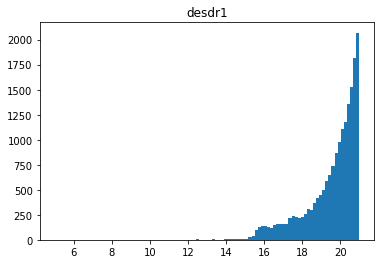

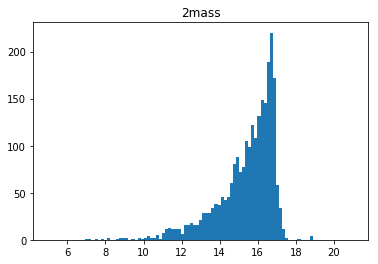

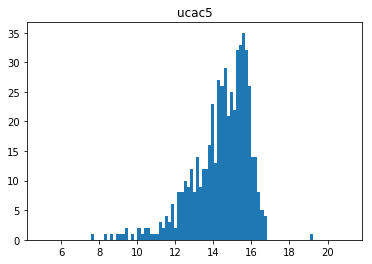

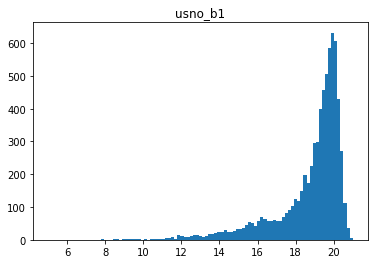

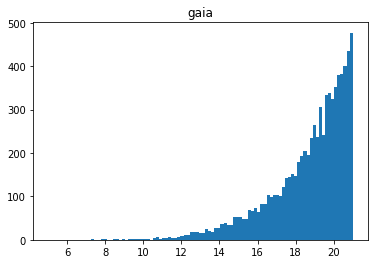

In [213]:
bins = np.linspace(5,21, 100)
for key in deshost_tables:
    plt.figure()
    plt.hist(deshost_tables[key][mag_field_names[key]], bins=bins)
    plt.title(key)

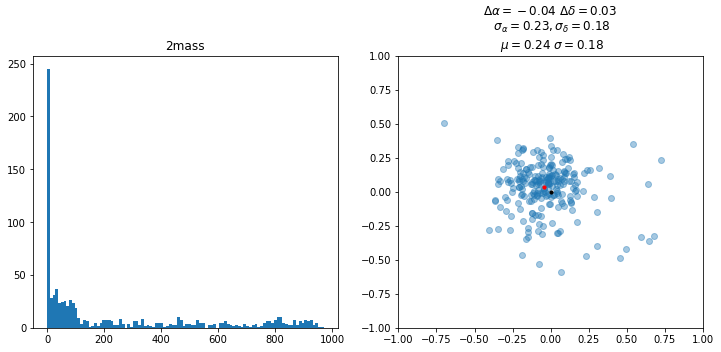

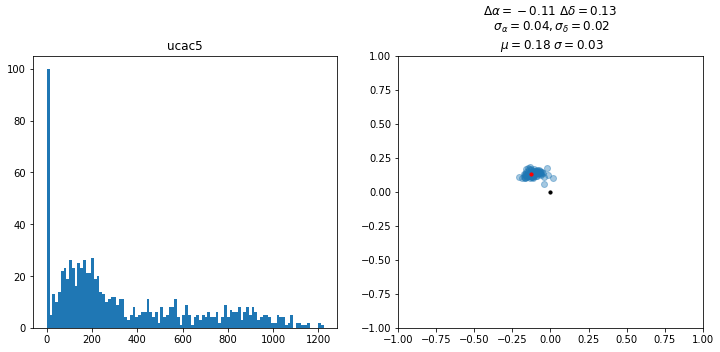

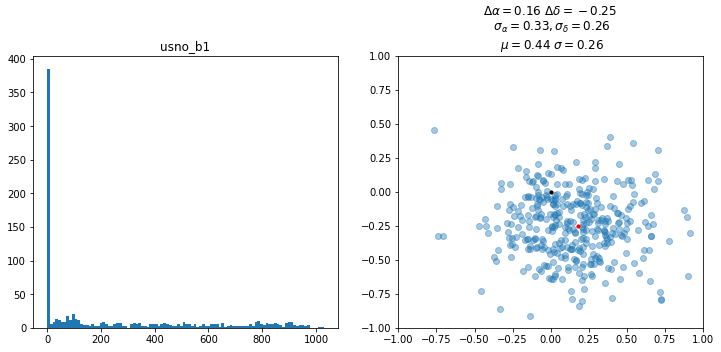

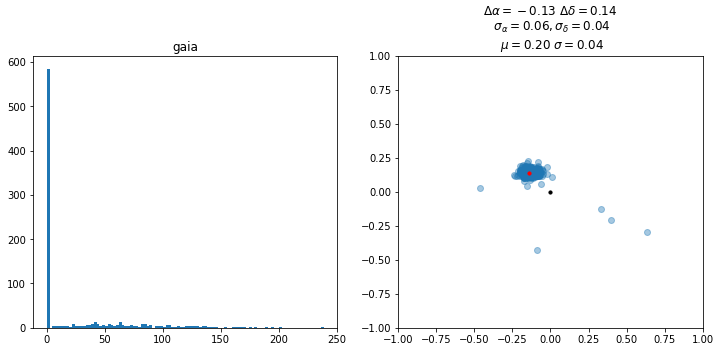

In [233]:
dsc = SkyCoord(deshost_tables['desdr1']['ra'], deshost_tables['desdr1']['dec'], unit=u.deg)
dmag = deshost_tables['desdr1'][mag_field_names['desdr1']]

magrng = (16, 17)
d_matchmag = 1

dsc_msk = dsc[(magrng[0]<dmag)&(dmag<magrng[1])]

for key in deshost_tables:
    if key == 'desdr1':
        continue
    t = deshost_tables[key]
    sc = SkyCoord(t['ra'], t['dec'], unit=u.deg)
    mag = t[mag_field_names[key]]
    sc_msk = sc[((magrng[0]-d_matchmag)<mag)&(mag<(magrng[1]+d_matchmag))]
    
    idx, d2d, _ = dsc_msk.match_to_catalog_sky(sc_msk)
    dra = dsc_msk.ra - sc_msk[idx].ra
    dracosdec = dra*np.cos(dsc_msk.dec)
    ddec = dsc_msk.dec - sc_msk[idx].dec
    
    sepmsk = d2d < 1.5*u.arcsec
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.hist(d2d.arcsec, bins=100)
    
    ax2.scatter((dracosdec)[sepmsk].arcsec, ddec[sepmsk].arcsec, alpha=.4)
    ax2.scatter([0], [0], c='k', s=10)
    ax2.scatter([np.mean(dra[sepmsk]).arcsec], [np.mean(ddec[sepmsk]).arcsec], c='r', s=10)
    ax2.set_xlim(-1, 1)
    ax2.set_ylim(-1, 1)
    fmt = (np.mean(dracosdec[sepmsk]).arcsec, np.mean(ddec[sepmsk]).arcsec, 
           np.std(dracosdec[sepmsk]).arcsec, np.std(ddec[sepmsk]).arcsec, 
           np.mean(d2d[sepmsk]).arcsec, np.std(d2d[sepmsk]).arcsec)
    ax2.set_title('$\\Delta \\alpha={:.2f}$ $\\Delta \\delta={:.2f}$ \n $\\sigma_\\alpha={:.2f}, \\sigma_\\delta={:.2f}$ \n $\\mu={:.2f}$ $\\sigma={:.2f}$'.format(*fmt))
    
    ax1.set_title(key)
    

The plots above are the same as above - they show the astrometric offsets between mag 16-17 DES stars to their matches in the astrometric sources.

Upshot: Gaia seems to work best by a fairly wide margin... But there is an astrometric offset at the ~tenths of an arcsecond level. Probably this is because 2MASS is the DES astrometric reference frame.  But it seems to be just an offset because the matches are otherwise very good.